In [21]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from unet_model import UNet
%matplotlib inline

torch.manual_seed(1337)
np.random.seed(1337)

In [22]:
class MyDataset(Dataset):

    def __init__(self, X_path="dataset/x_train.npy", y_path="dataset/y_train.npy", transform=None):
        self.X = np.load(X_path).transpose(0, 3, 1, 2)
        self.y = np.load(y_path)
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            sample = self.transform(self.X[idx])
            return sample, np.expand_dims(self.y[idx], 0)
        else:
            return self.X[idx], np.expand_dims(self.y[idx], 0)
        
data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [23]:
test_dataset = MyDataset("dataset/x_test.npy", "dataset/y_test.npy")

batch_size = 1

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
device = "cuda"
model = UNet(3, 1, bilinear=False)

model.load_state_dict(torch.load("models/UnetLogMSE/model_100.pth"))

model = model.to(device)

In [40]:
def logMSE(pred, groundtruth):
    log_pred = torch.log(pred)
    log_gt = torch.log(groundtruth)
    loss = 0.5*torch.mean((log_pred - log_gt + torch.mean(log_gt - log_pred))**2)
    return loss

def test():
    images, predictions, ground_truths = [], [], []
    model.eval()
    test_loss = 0
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data.float())
        test_loss += logMSE(output, target).item() # sum up batch loss
        images.append(data.detach().cpu())
        predictions.append(output.detach().cpu())
        ground_truths.append(target.detach().cpu())

    test_loss /= len(test_loader.dataset)
    print(f'test set: Average loss: {test_loss}')
    
    return images, predictions, ground_truths
    
images, predictions, ground_truths = test()

  0%|          | 0/145 [00:00<?, ?it/s]

test set: Average loss: 0.06924335663046302


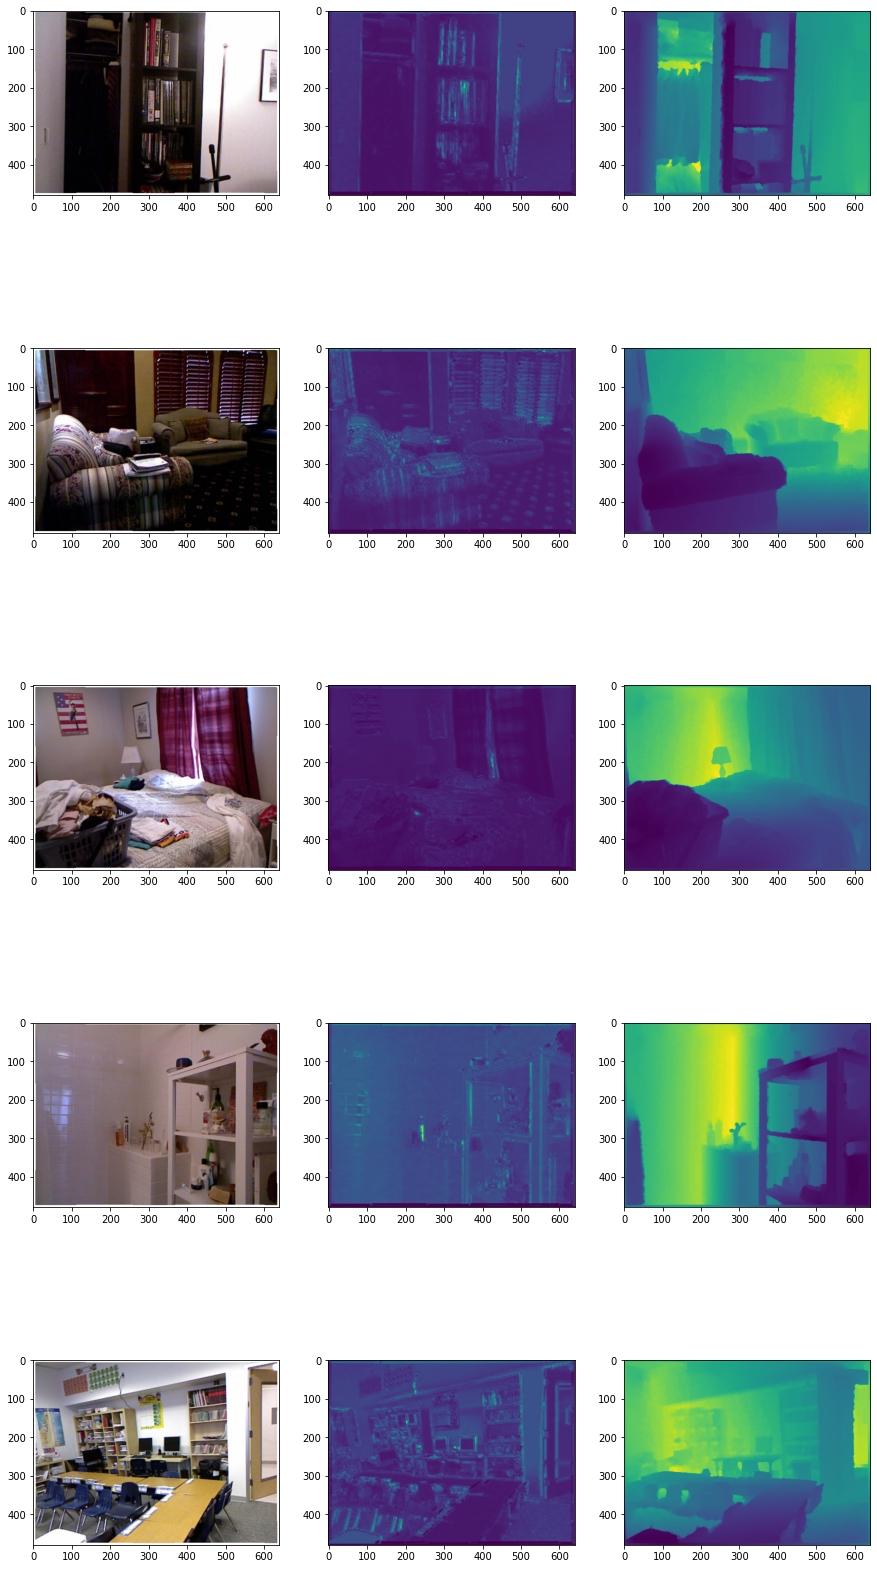

In [41]:
#log mse loss

fig, axes = plt.subplots(5, 3, figsize=(15, 30))
for i,ax in enumerate(axes):
    image = np.squeeze(images[i])
    pred = torch.exp(np.squeeze(predictions[i]))
    ground_truth = np.squeeze(ground_truths[i])
    
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(pred)
    ax[2].imshow(ground_truth)

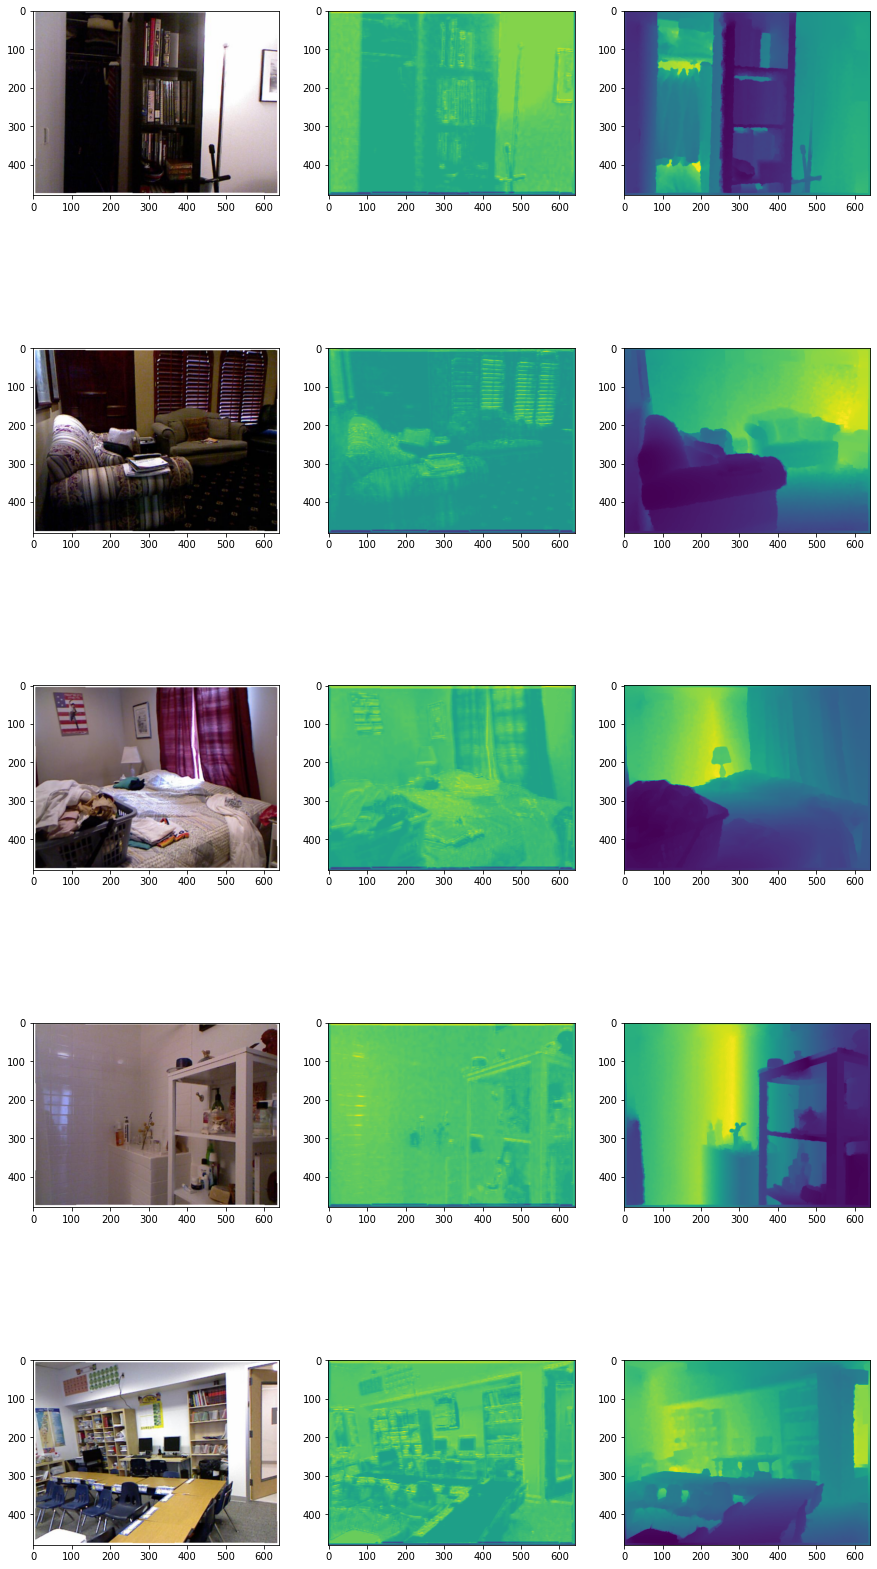

In [11]:
#l2 loss

fig, axes = plt.subplots(5, 3, figsize=(15, 30))
for i,ax in enumerate(axes):
    image = np.squeeze(images[i])
    pred = np.squeeze(predictions[i])
    ground_truth = np.squeeze(ground_truths[i])
    
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(pred)
    ax[2].imshow(ground_truth)

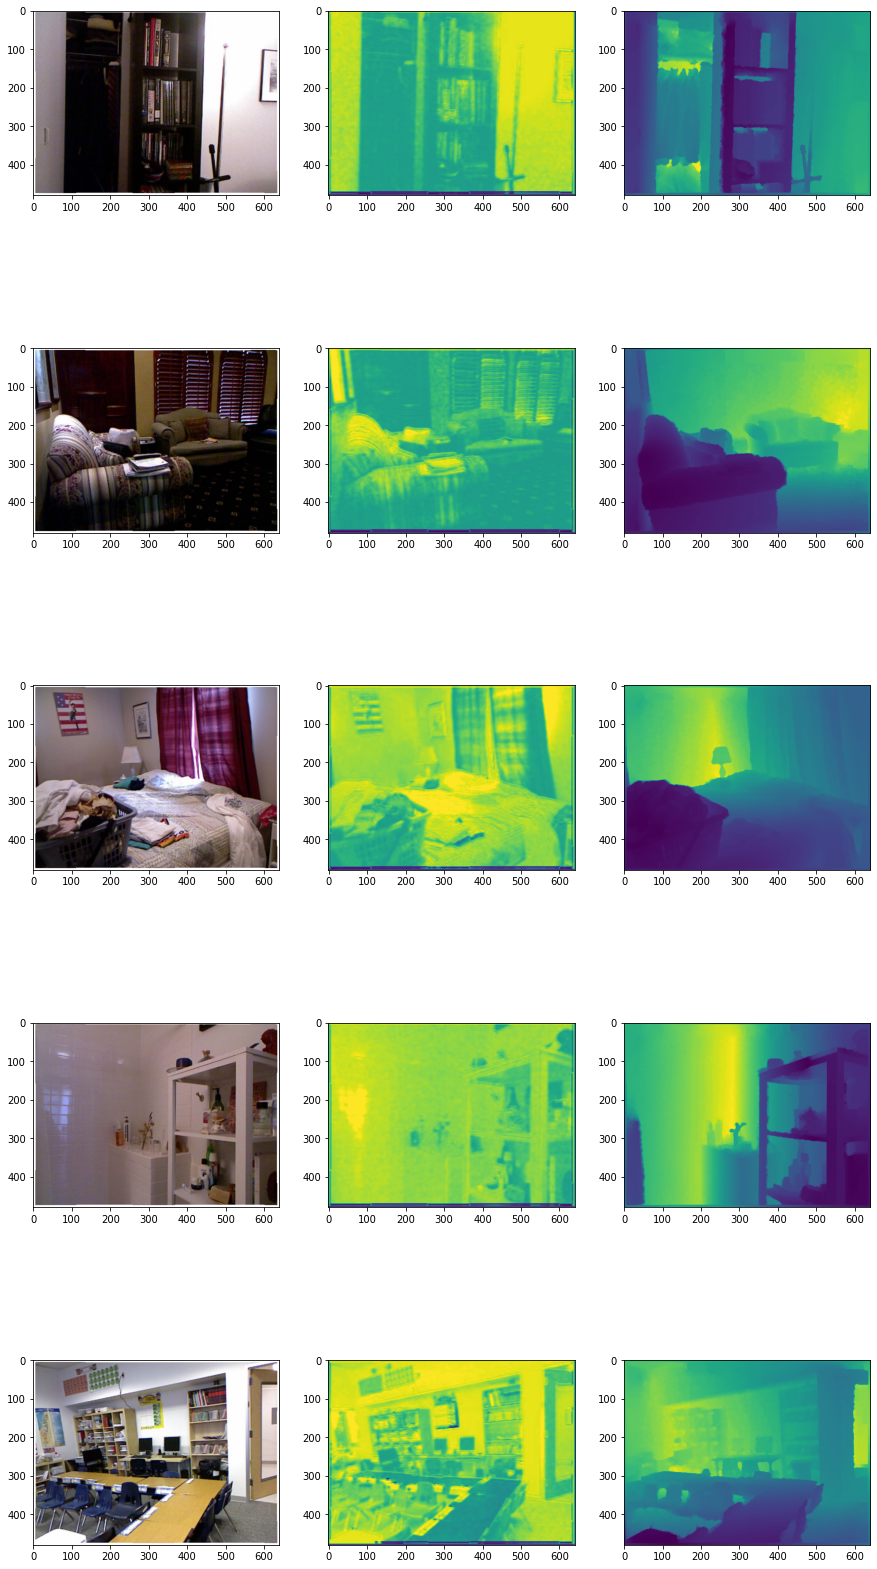

In [13]:
#l1 loss

fig, axes = plt.subplots(5, 3, figsize=(15, 30))
for i,ax in enumerate(axes):
    image = np.squeeze(images[i])
    pred = np.squeeze(predictions[i])
    ground_truth = np.squeeze(ground_truths[i])
    
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(pred)
    ax[2].imshow(ground_truth)